In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Step 1: Generate non-linear concentric circles dataset
# Why: To demonstrate need for kernel – linear separation impossible
def generate_circles_data(n_samples=100, noise=0.1, random_seed=42):
    np.random.seed(random_seed)
    n_half = n_samples // 2
    
    # Inner circle: class -1
    radius_inner = np.random.uniform(0, 0.5, n_half)
    angle_inner = np.random.uniform(0, 2 * np.pi, n_half)
    X_inner = np.column_stack((radius_inner * np.cos(angle_inner),
                               radius_inner * np.sin(angle_inner)))
    y_inner = -np.ones(n_half)
    
    # Outer circle: class +1
    radius_outer = np.random.uniform(0.8, 1.2, n_half)
    angle_outer = np.random.uniform(0, 2 * np.pi, n_half)
    X_outer = np.column_stack((radius_outer * np.cos(angle_outer),
                               radius_outer * np.sin(angle_outer)))
    X_outer += noise * np.random.randn(n_half, 2)
    y_outer = np.ones(n_half)
    
    X = np.vstack((X_inner, X_outer))
    y = np.hstack((y_inner, y_outer))
    return X, y

X, y = generate_circles_data()
print(f"Data shape: {X.shape}, Labels: {np.unique(y)}")

Data shape: (100, 2), Labels: [-1.  1.]


In [4]:
# Step 2: Define RBF kernel function
# Why: Computes similarity in infinite-dimensional space without explicit mapping
def rbf_kernel(X1, X2, gamma=1.0):
    # Efficient computation using broadcasting
    sq_dists = np.sum(X1**2, axis=1)[:, np.newaxis] + \
               np.sum(X2**2, axis=1)[np.newaxis, :] - \
               2 * np.dot(X1, X2.T)
    return np.exp(-gamma * sq_dists)


In [5]:
# Step 3: Simple SVM dual solver using clipping method (for educational purposes)
# Why: Full QP solvers not available; this iterative method works for small n
class SimpleKernelSVM:
    def __init__(self, C=1.0, gamma=1.0, tol=1e-3, max_iter=1000):
        self.C = C
        self.gamma = gamma
        self.tol = tol
        self.max_iter = max_iter
    
    def fit(self, X, y):
        n_samples = X.shape[0]
        self.X_train = X
        self.y_train = y
        
        # Compute Gram matrix once
        K = rbf_kernel(X, X, self.gamma)
        
        # Initialize alphas
        alphas = np.zeros(n_samples)
        
        for _ in range(self.max_iter):
            alpha_prev = np.copy(alphas)
            
            for i in range(n_samples):
                # Compute f(x_i)
                f_i = np.sum(alphas * y * K[:, i]) + self.b if hasattr(self, 'b') else 0
                
                # Gradient step direction
                grad = 1 - y[i] * f_i
                
                if grad != 0:
                    # Simple update with bounds
                    new_alpha = alphas[i] + grad / K[i, i]
                    alphas[i] = np.clip(new_alpha, 0, self.C)
            
            # Enforce sum alpha_i y_i = 0 approximately (simple projection)
            violation = np.sum(alphas * y)
            if abs(violation) > 1e-6:
                alphas -= violation * y / np.sum(y**2)
                alphas = np.clip(alphas, 0, self.C)
            
            # Check convergence
            if np.linalg.norm(alphas - alpha_prev) < self.tol:
                break
        
        # Compute bias from support vectors (alpha > tol)
        support_idx = alphas > self.tol
        if np.any(support_idx):
            self.b = np.mean(y[support_idx] - np.sum(alphas[support_idx] * y[support_idx] * K[support_idx][:, support_idx], axis=1))
        else:
            self.b = 0
        
        self.alphas = alphas
        self.support_idx = support_idx
    
    def predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, self.gamma)
        scores = np.sum(self.alphas[self.support_idx] * self.y_train[self.support_idx] * K_test[:, self.support_idx], axis=1) + self.b
        return np.sign(scores)


In [6]:
# Step 4: Train the model
svm = SimpleKernelSVM(C=10.0, gamma=5.0)  # Tune gamma and C as needed
svm.fit(X, y)

In [7]:
# Step 5: Predict on training data for accuracy
y_pred = svm.predict(X)
accuracy = np.mean(y_pred == y)
print(f"Training Accuracy: {accuracy:.3f}")
print(f"Number of Support Vectors: {np.sum(svm.support_idx)}")

Training Accuracy: 0.980
Number of Support Vectors: 100


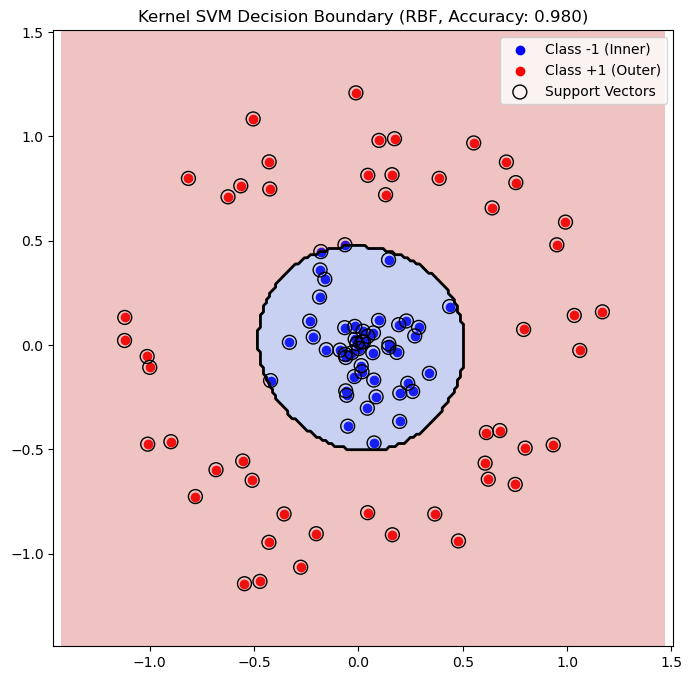

In [8]:
# Step 6: Plot decision boundary
def plot_decision_boundary(svm, X, y):
    plt.figure(figsize=(8, 8))
    # Plot data points
    plt.scatter(X[y==-1][:,0], X[y==-1][:,1], c='blue', label='Class -1 (Inner)')
    plt.scatter(X[y==1][:,0], X[y==1][:,1], c='red', label='Class +1 (Outer)')
    
    # Create grid for contour
    margin = 0.3
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-margin, X[:,0].max()+margin, 200),
                         np.linspace(X[:,1].min()-margin, X[:,1].max()+margin, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = svm.predict(grid)
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.contour(xx, yy, Z, levels=[0], colors='black', linewidths=2)
    
    # Plot support vectors
    sv = X[svm.support_idx]
    plt.scatter(sv[:,0], sv[:,1], s=100, facecolors='none', edgecolors='black', label='Support Vectors')
    
    plt.legend()
    plt.title(f"Kernel SVM Decision Boundary (RBF, Accuracy: {accuracy:.3f})")
    plt.axis('equal')
    plt.show()

plot_decision_boundary(svm, X, y)